# Data Collection and Analysis Using AEPsych

This tutorial serves as a complete example on how to collect and analyze data from perceptual experiments using AEPsych. For more information on AEPsych, refer to the documentation in the [GitHub repository](https://github.com/facebookresearch/aepsych). 

This tutorial demonstrates how to create an experiment to measure one's detection threshold for orientation. On each trial of the experiment, the participant is shown two gabor-patch stimuli, one oriented vertically (the foil) and one oriented at an angle (the target). The goal of the experiment is to find the smallest angle at which the participant can reliably identify the target. You can run the code blocks below interactively to participate in the experiment yourself, or you can simply view data collected from an example participant.

## Experiment Overview
Below we define the functions we will need to conduct our experiment. Note that the code here is mainly for demonstration purposes and should not be used for serious experiments. If you would like to run psychophysics experiments in Python, consider using [Psychopy](https://www.psychopy.org/).

In [1]:
import math
from IPython import get_ipython 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
import random

fig_size = 15

# Show a fixation cross with a blank background
def show_fixation_cross():
    _, ax = plt.subplots(1, figsize=(fig_size, fig_size/2))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False,
                left=False, labelleft=False)
    ax.text(0.5, 0.5, '+', size=100,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)
    ax.axis('off')
    ax.grid(visible=None)
    plt.show()

# Evaluate the gabor filter function at an x,y position
def gabor(x, y, theta):
    f = 0.05
    sigma = 25

    x_ = x * math.cos(theta) + y * math.sin(theta)
    y_ = y * math.cos(theta) - x * math.sin(theta)
    num = x_ ** 2 + y_ ** 2
    return math.exp(num / (-2 * sigma**2)) * math.cos(2 * math.pi * f * x_)

# Show a gabor patch
def show_gabor(theta, ax):
    # The size of the gabor patch
    radius = 60

    # Convert from degrees to radians
    theta = math.radians(theta)

    M = np.array([[gabor(i, j, theta) for j in range(-radius, radius)] for i in range(-radius, radius)])
    M = ((M - M.min())) / (M.max() - M.min())

    ax.axis('off')
    ax.grid(visible=None)
    ax.imshow(M.T, cmap=cm.Greys_r)


def run_trial(angle, trial_number):
    fixation_duration = 1
    trial_duration = 0.5

    # Show the fixation cross
    show_fixation_cross()
    time.sleep(fixation_duration)
    clear_output(wait=True)

    # randomly select if target should go on left or right side
    right_side = random.choice([0, 1])

    # randomly select if target angle should be clockwise or counterclockwise
    direction = random.choice([-1, 1])
    angle *= direction

    # Show the foil and target
    _, axs = plt.subplots(1, 2, figsize=(fig_size, fig_size))
    show_gabor(angle, axs[right_side])
    show_gabor(0, axs[int(not right_side)])

    # Ask for the participant's response
    ans = None
    ans_key = {'j': 1, 'J': 1, 'f': 0, 'F': 0}
    while ans not in ans_key:
        plt.show()
        time.sleep(trial_duration)
        clear_output()
        ans = input(f"Trial #{trial_number}: Which side was angled? (Enter 'F' for left or 'J' for right)")

    # Check if the response was correct
    is_correct = int(ans_key[ans] == right_side)
    target_side = "right" if right_side else "left"
    
    return is_correct, target_side


On each trial of the experiment, the participant will first see a white box with fixation cross for 1 second. The box looks like this:

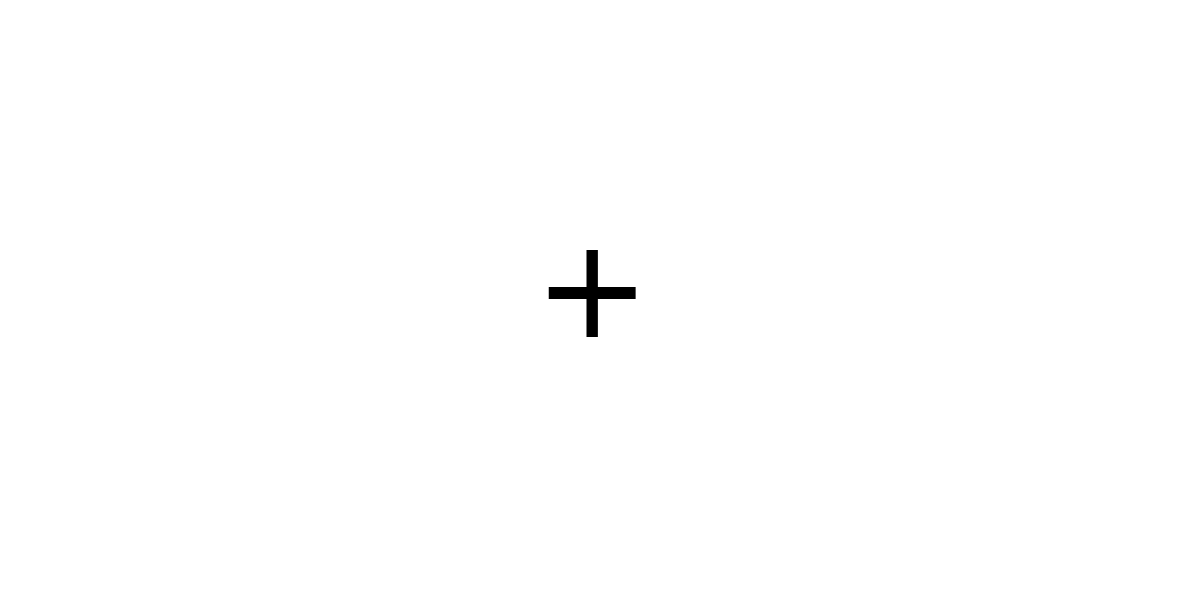

In [2]:
show_fixation_cross()

After 1 second, the fixation cross will disappear, and two gabor patches will appear side-by-side. One patch will be the foil with a vertical orientation, and one will be the target with an angled orientation. The position of the target and whether the angle is measured clockwise or counterclockwise is randomized each trial. An example foil and target are shown below:

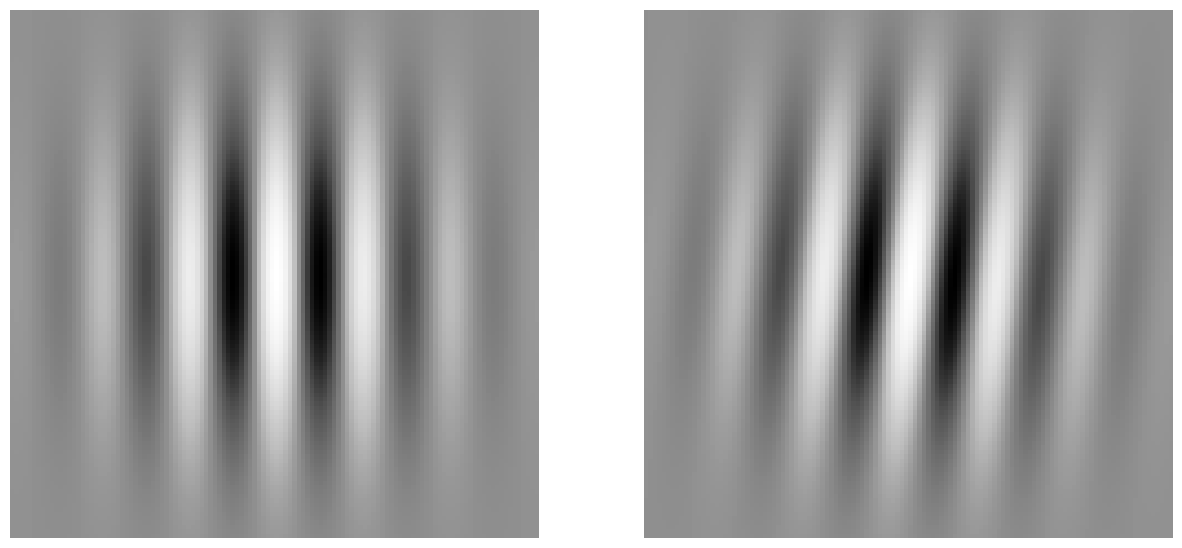

In [3]:
_, axs = plt.subplots(1, 2, figsize=(fig_size, fig_size))
show_gabor(0, axs[0])
show_gabor(5, axs[1])

After 0.5 seconds, the patches will disappear, and the participant will be prompted to report which one was the target by typing "F" for left or "J" for right, and then hitting enter. Try running the code block below to experience a trial for yourself. The `run_trial` function takes an angle and a trial number as input and returns whether or not you were correct (1 for correct, 0 for incorrect), as well as the side which the target was actually on. 

In [4]:
run_trial(5, 0)

(1, 'right')

## Starting the AEPsych Server
The code block below starts an AEPsych server that will run in the background (you can also start the server by running the second line in a command prompt). We can contact the server at IP address 0.0.0.0, port 5555, and the data will be saved in a database named "data_collection_analysis_tutorial.db". In this tutorial, we will run the server on the same computer as the experiment, but it is also possible to run the server remotely. 

In [5]:
from aepsych.server import AEPsychServer
from aepsych_client import AEPsychClient

server = AEPsychServer(database_path="data_collection_analysis_tutorial.db")
client = AEPsychClient(server=server)

2023-03-12 18:26:52,013 [INFO   ] No DB found at data_collection_analysis_tutorial.db, creating a new DB!


We tell the server what kind of experiment we are running by sending it a configure message (see the [configs folder](https://github.com/facebookresearch/aepsych/tree/main/configs) for some examples. The gist of the config here is that it is telling the server that our experiment will have one parameter called "angle", which will range from 0.1 to 5 degrees. (If you run this experiment on yourself and find that this range of angles makes the experiment too easy or too hard, you can adjust the `lb` and `ub` values in the string below). This experiment will last for 50 trials. The parameter values from the first 10 trials will be drawn from the [Sobol sequence](https://en.wikipedia.org/wiki/Sobol_sequence), to provide some initial data to initialize AEPsych's model; the following 40 trials will be drawn from that model. In this case, the model will be a classification [Gaussian Process](https://en.wikipedia.org/wiki/Gaussian_process) (GP). 

GPs can be thought of as generalizations of traditional psychophysics models that can handle multiple dimensions and allow the response function to be nonlinear (for further discussion see the [AEPsych preprint](https://arxiv.org/abs/2104.09549)). Furthermore, GPs can be used in conjunction with acquisition functions to perform [active learning](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)--that is, the model can determine which points in the parameter space should be sampled next to achieve some goal. In this case we use the [level set estimation](https://www.ijcai.org/Proceedings/13/Papers/202.pdf) function to find the angle at which the participant will correctly identify the target 75% of the time. 

GPs are defined by a mean function and covariance function. Because we don't define what these functions should be in the config, they revert to their default values of a constant mean function, and a [radial basis covariance function](https://en.wikipedia.org/wiki/Radial_basis_function). These functions are fine for parameter space we want to explore here, but if we wanted to expand our search across a larger range of angles, we would probably want to use a periodic covariance function to account for that fact that angles loop every 360 degrees.

In [6]:
config_str = """
[common]
use_ax = True
parnames = [theta] # names of the parameters
lb = [0.1] # lower bound of the parameter
ub = [5] # upper bound of parameter
stimuli_per_trial = 1 # the number of stimuli shown in each trial; 1 for single, or 2 for pairwise experiments
outcome_types = [binary] # the type of response given by the participant; can be [binary] or [continuous]
target = 0.75 # desired threshold, for threshold estimation.
strategy_names = [init_strat, opt_strat] # The strategies that will be used, corresponding to the named sections below

# Configuration for the initialization strategy, which we use to gather initial points
# before we start doing model-based acquisition
[init_strat]
min_total_tells = 10 # number of sobol trials to run
generator = SobolGenerator # The generator class used to generate new parameter values

# Configuration for the optimization strategy, our model-based acquisition
[opt_strat]
min_total_tells = 25 # total number of trials to run
refit_every = 1 # how often to refit the model from scratch
generator = OptimizeAcqfGenerator # The generator class used to generate new parameter values
acqf = MCLevelSetEstimation # The acquisition function; MCLevelSetEstimation is used for threshold finding
model = ContinuousRegressionGP # The model class
"""

client.configure(config_str=config_str, config_name="1d_gabor_config")

2023-03-12 18:26:52,283 [INFO   ] Received msg [setup]


Now that we have set up our client and configured our server, we can start collecting data. The basic loop of the experiment is as follows:

1. Ask AEPsych what value of our parameter, angle, to try next.
2. Run a trial using this suggested value.
3. Tell AEPsych the particant's response so that it can update its model.
4. Repeat for the specified number of trials.

We ask AEPsych for parameters by calling client.ask(). This returns a dictionary with two entries. The first, `'config'`, contains another dictionary whose keys are the names of your parameters, and whose values are lists of parameter values to try. The second, `'is_finished'`, is a bool indicating whether the number of trials specified in the config have been completed.

In [7]:
client.ask()

c:\Users\ckamd\anaconda3\envs\aepsych\lib\site-packages\ax\core\observation.py:274: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

2023-03-12 18:26:52,489 [INFO   ] Received msg [ask]


{'config': {'theta': [4.090344277583063]}, 'is_finished': False}

We tell AEPsych about the parameter values we have tried by calling client.tell(). This method has two required arguments. The first, config, is a dictionary representing the set of parameter values you would like to tell AEPsych about, and takes the same format as the 'config' entry from client.ask(). The second argument is the binary outcome of a trial, indicated by 0 (the participant did not identify the target) or 1 (the participant did identify the target). This method also optionally takes other keyword arguments that will be stored as metadata in AEPsych's database. For our experiment, we will record which side the target was on.

In [8]:
client.tell(config={'theta':[0.1]}, outcome=0, target_side='right')

2023-03-12 18:26:52,618 [INFO   ] Received msg [tell]


The code below asks AEPsych for parameter values and runs trials until the experiment is completed:

In [9]:
trial_number = 1
while True:
    response = client.ask()
    if response['is_finished']:
        break
    theta = response["config"]["theta"][0]
    outcome, target_side = run_trial(theta, trial_number)
    client.tell(config={"theta": [theta]}, outcome=outcome, target_side=target_side)
    trial_number += 1

2023-03-12 18:28:50,603 [INFO   ] Received msg [tell]
2023-03-12 18:28:50,841 [INFO   ] Recording strat because the experiment is complete.
2023-03-12 18:28:51,407 [INFO   ] Received msg [ask]


Note that even after the number of trials specified in the config have completed, you can still ask for more parameter values and conduct more trials:

In [10]:
client.ask()

2023-03-12 18:28:51,707 [INFO   ] Received msg [ask]


{'config': {'theta': []}, 'is_finished': True}

You are also not restricted to only using the parameter values that AEPsych suggests. You can tell it the outcome of any parameter values that you would like:

In [11]:
client.tell(config={'theta':[5.0]}, outcome=1, target_side='left')

2023-03-12 18:28:51,786 [INFO   ] Received msg [tell]
2023-03-12 18:28:51,984 [INFO   ] Recording strat because the experiment is complete.


Once you are done collecting data, you can close the server by calling `client.finalize()`

In [12]:
client.finalize()

2023-03-12 18:28:52,146 [INFO   ] Received msg [exit]
2023-03-12 18:28:52,147 [INFO   ] Got termination message!
2023-03-12 18:28:52,148 [INFO   ] Dumping strats to DB due to Normal termination.


## Replaying the Experiment and Analyzing Data
To analyze the data, we open the database with an `AEPsychServer` object. This server runs here in the notebook rather than in the background like the server we used to collect data.

In [13]:
from aepsych.server import AEPsychServer

serv = AEPsychServer(database_path="data_collection_analysis_tutorial.db")

2023-03-12 18:28:52,328 [INFO   ] Found DB at data_collection_analysis_tutorial.db, appending!


The database is made of a set of experiments, which have unique experiment UUIDs. Every time the server is started (e.g. from the command line), a new experiment id is generated. For a list of all experiment ids:

In [14]:
exp_ids = [rec.experiment_id for rec in serv.db.get_master_records()]
print(exp_ids)

['fcb9da2d-d335-4edb-aacc-475634cbda46']


The above indicates that there is only 1 experiment_id in this database.

Note that the above commands do not actually load any of the experiment data from the database. The data is only loaded when you run serv.replay to replay all of the setup, ask, and tell messages that are recorded in the database. We will pass skip_computations = True to this method to skip all of the model-fitting computations and make the replay finish faster.

In [15]:
serv.replay(exp_ids[-1], skip_computations=True)

2023-03-12 18:28:52,537 [INFO   ] skip_computations=True, make sure to refit the final strat before doing anything!
2023-03-12 18:28:52,561 [INFO   ] Received msg [setup]
2023-03-12 18:28:52,580 [INFO   ] Received msg [ask]
2023-03-12 18:28:52,583 [INFO   ] Received msg [tell]
2023-03-12 18:28:52,625 [INFO   ] Received msg [ask]
2023-03-12 18:28:52,630 [INFO   ] Received msg [tell]
2023-03-12 18:28:52,695 [INFO   ] Received msg [ask]
2023-03-12 18:28:52,698 [INFO   ] Received msg [tell]
2023-03-12 18:28:52,754 [INFO   ] Received msg [ask]
2023-03-12 18:28:52,757 [INFO   ] Received msg [tell]
2023-03-12 18:28:52,820 [INFO   ] Received msg [ask]
2023-03-12 18:28:52,822 [INFO   ] Received msg [tell]
2023-03-12 18:28:52,903 [INFO   ] Received msg [ask]
2023-03-12 18:28:52,906 [INFO   ] Received msg [tell]
2023-03-12 18:28:53,001 [INFO   ] Received msg [ask]
2023-03-12 18:28:53,004 [INFO   ] Received msg [tell]
2023-03-12 18:28:53,108 [INFO   ] Received msg [ask]
2023-03-12 18:28:53,111 [IN

The data has been loaded into the servers list of strategies, which we can access through `serv._strats`. Per our config string, we have two strategies, the first being the model-less initialization strategy, and the second being the model-based threshold-finding strategy. We can see the model-based strategy's data using the `strat.ax_client.experiment`'s `trials` and `fetch_data` methods.

In [16]:
strat = serv._strats[-1]
model_data = strat.ax_client.experiment.fetch_data()._df
model_data.index = model_data['trial_index']
model_data = model_data.rename(columns={'mean': 'Y'})
x = np.array([strat.ax_client.experiment.trials[trial_key].arm.parameters['theta'] for trial_key in strat.ax_client.experiment._data_by_trial.keys()])
model_data = model_data.drop(columns=['arm_name', 'sem', 'metric_name', 'trial_index'])
model_data['X'] = x

model_data

,Y,X
trial_index,,
0,0.0,0.100000
1,1.0,2.653157
2,1.0,3.481613
3,1.0,2.380847
4,0.0,0.313516
5,1.0,1.474657
6,1.0,3.861562
7,1.0,0.229492
8,1.0,2.281265


Since we passed `skip_computations = True` into the replay method before, we will have to manually refit the strategy's model:

In [17]:
strat.ax_client.fit_model()

c:\Users\ckamd\anaconda3\envs\aepsych\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning:

Input data is not standardized. Please consider scaling the input to zero mean and unit variance.

2023-03-12 18:28:56,730 [INFO   ] Starting fit...
2023-03-12 18:28:57,141 [INFO   ] Fit done, time=0.4084610939025879
c:\Users\ckamd\anaconda3\envs\aepsych\lib\site-packages\botorch\models\utils\assorted.py:201: InputDataWarning:

Input data is not standardized. Please consider scaling the input to zero mean and unit variance.

2023-03-12 18:28:57,165 [INFO   ] Starting fit...
2023-03-12 18:28:57,474 [INFO   ] Fit done, time=0.30837345123291016


We can now plot the posterior of the fitted model:

In [18]:
strat.plot_slice('theta')

In this plot, the black dots at the bottom with an objective of 0 represent angles at which the participant did not successfully identify the target, while the black dots up with an objective of 1 represents the angles at which the participant successfully identified the target. The dark blue curve represents the model's posterior probabilty that the participant would select the target, with 95% of the posterior mass lying in the shaded region. If you are viewing the data from the example participant, you will see that their threshold(75% probability) is somewhere between about 0.5 and 1.5 degrees (note, however, that threshold estimation for non-monotonic models may not always be accurate; we are working on better algorithms for this). More data could be collected to reduce this uncertainty. If you collected data on your own data, your plot may look different; there are often large individual differences in psychophysics tasks. In any case you should see that most of the sampled points are near the estimated threshold; the level set estimation algorithm intelligently selects points so that time is not wasted collecting data at points far away from the threshold, allowing for a more accurate threshold estimate in fewer trials than traditional methods.

## Conclusion

This tutorial has shown a complete example of how to conduct an AEPsych experiment and analyze the data. You can easily adapt this code for your own needs by changing the config string and the code that runs trials. If you need any help debugging or setting up your experiment, you can [open a GitHub issue](https://github.com/facebookresearch/aepsych/issues). You can also try conducting AEPsych experiments without writing any code, by running [this notebook](https://github.com/facebookresearch/aepsych/blob/main/examples/Interactive_AEPsych.ipynb).